# ABIDE Subtype analysis
The goal of this notebook is to run a subtype analysis on the ABIDE dataset and to look at the subtype weights following Pierre Orban's analysis. Here are the central research questions:

1. What are subtypes of scores maps for different networks (7 network resolution on Cambridge) and how do they look like?
2. What are the individual subject weights for these subtypes (violin plots and Pierre's matrix)
3. For which networks and subtypes is diagnosis a significant predictor of weights?
4. What do weights for these subtypes and networks look like for patients and healthy controls?
5. For which networks and subtypes are dimensional scores like IQ significant predictors of weights?
5. What does the scatterplot of weights over IQ look like?

In [91]:
# Imports
import os
import glob
import numpy as np
import pandas as pd
import nibabel as nib
import brainbox as bb
import nilearn as nil
import statsmodels.api as sm
from scipy import stats as st
from matplotlib import gridspec
from scipy import cluster as scl
from nilearn import plotting as nlp
from matplotlib import pyplot as plt
from sklearn import linear_model as slin
from statsmodels.sandbox import stats as sts
from matplotlib.colors import LinearSegmentedColormap
from statsmodels.sandbox.stats import multicomp as smi

In [92]:
%matplotlib inline

# Paths

In [93]:
# Paths
scale = 20
name = 'n308_sample'
mtp = 'stability_maps'
prior_path = '/data1/cambridge/template/template_cambridge_basc_multiscale_sym_scale{:03d}.nii.gz'.format(scale)
pheno_path = '/data1/abide/Pheno/unconstrained_2box_308_sample.csv'
netstack_path = '/data1/subtypes/serial_preps/netstack_demeaned_{}_scale_{:03d}.npy'.format(name, scale)
netraw_path = '/data1/subtypes/serial_preps/netstack_raw_{}_scale_{:03d}.npy'.format(name, scale)
corrmat_path = '/data1/subtypes/serial_preps/correlation_matrix_{}_scale_{:03d}.npy'.format(name, scale)
mask_path = '/data1/abide/Mask/mask_data_specific.nii.gz'
out_path = '/data1/subtypes/sc12'

In [94]:
# Get the mask
m_img = nib.load(mask_path)
mask_data = m_img.get_data()
mask = mask_data != 0

In [95]:
# Get the phenotype data
pheno = pd.read_csv(pheno_path)

In [96]:
# add coded variable for ratio of VIQ and PIQ
pheno['VerbRatio'] = pheno['VIQ'] / pheno['PIQ']

In [97]:
# Get the prior
p_img = nib.load(prior_path)
prior = p_img.get_data()

In [98]:
# Turn the priors into an image
prior = nib.load(prior_path)
prior_data = prior.get_data()
prior_temp = np.zeros((prior_data.shape + (scale,)))
for sc_id in range(scale):
    tmp = np.zeros_like(prior_data)
    tmp[prior_data==sc_id+1] = sc_id + 1
    prior_temp[..., sc_id] = tmp
prior_img = nib.Nifti1Image(prior_temp, affine=m_img.get_affine(), header=m_img.get_header())

In [99]:
pheno.columns.values

array(['SITE_ID', 'SUB_ID', 'DX_GROUP', 'DSM_IV_TR', 'AGE_AT_SCAN', 'SEX',
       'HANDEDNESS_CATEGORY', 'HANDEDNESS_SCORES', 'FIQ', 'VIQ', 'PIQ',
       'FIQ_TEST_TYPE', 'VIQ_TEST_TYPE', 'PIQ_TEST_TYPE',
       'ADI_R_SOCIAL_TOTAL_A', 'ADI_R_VERBAL_TOTAL_BV', 'ADI_RRB_TOTAL_C',
       'ADI_R_ONSET_TOTAL_D', 'ADI_R_RSRCH_RELIABLE', 'ADOS_MODULE',
       'ADOS_TOTAL', 'ADOS_COMM', 'ADOS_SOCIAL', 'ADOS_STEREO_BEHAV',
       'ADOS_RSRCH_RELIABLE', 'ADOS_GOTHAM_SOCAFFECT', 'ADOS_GOTHAM_RRB',
       'ADOS_GOTHAM_TOTAL', 'ADOS_GOTHAM_SEVERITY', 'SRS_VERSION',
       'SRS_RAW_TOTAL', 'SRS_AWARENESS', 'SRS_COGNITION',
       'SRS_COMMUNICATION', 'SRS_MOTIVATION', 'SRS_MANNERISMS',
       'SCQ_TOTAL', 'AQ_TOTAL', 'COMORBIDITY', 'CURRENT_MED_STATUS',
       'MEDICATION_NAME', 'OFF_STIMULANTS_AT_SCAN',
       'VINELAND_RECEPTIVE_V_SCALED', 'VINELAND_EXPRESSIVE_V_SCALED',
       'VINELAND_WRITTEN_V_SCALED', 'VINELAND_COMMUNICATION_STANDARD',
       'VINELAND_PERSONAL_V_SCALED', 'VINELAND_DOMESTIC_

# Define some functions and the niak colormap

In [100]:
# Define a new colormap
cdict = {'red':   ((0.0, 0.0, 0.0),
                   (0.5, 0.0, 0.0),
                   (0.75, 1.0, 1.0),
                   (1.0, 1.0, 1.0)),

         'green': ((0.0, 1.0, 1.0),
                   (0.25, 0.0, 0.0),
                   (0.5, 0.0, 0.0),
                   (0.75, 0.0, 0.0),
                   (1.0, 1.0, 1.0)),

         'blue':  ((0.0, 1.0, 1.0),
                   (0.25, 1.0, 1.0),
                   (0.5, 0.0, 0.0),
                   (1.0, 0.0, 0.0))
        }
hotcold = LinearSegmentedColormap('hotcold', cdict)

In [101]:
def show_subtype(net_id, sbt_id, gdavg_img, sbt_store,
                 sbt_store_demeaned, view_mode='x', threshold=0.1, 
                 view_range=[-70,-50, -30, -10, 10, 30, 50, 70]):
    # Show the subtype
    fig = plt.figure(figsize=(24,50))
    gs = gridspec.GridSpec(12, 2, hspace=0.3)

    ax1 = fig.add_subplot(gs[0,0])
    nlp.plot_glass_brain(nil.image.index_img(gdavg_img, net_id), cmap=plt.cm.gnuplot, 
                             axes=ax1, colorbar=False, title='Scores average network {}'.format(net_id+1),
                            vmin=0, vmax=1)

    ax2 = fig.add_subplot(gs[0,1])
    # Turn the vectorized subtype into a volume
    sbt = sbt_store[net_id,sbt_id,:]
    tmp = np.zeros_like(mask, dtype=np.float)
    tmp[mask] = sbt
    sbt_img = nib.Nifti1Image(tmp, affine=m_img.get_affine(), header=m_img.get_header())
    nlp.plot_glass_brain(sbt_img, cmap=plt.cm.gnuplot, 
                         axes=ax2, colorbar=True, title='Subtype {} network {}'.format(sbt_id+1, net_id+1),
                        vmin=0, vmax=1)
    
    ax3 = fig.add_subplot(gs[1,:])
    # Turn the vectorized demeaned subtype into a volume
    sbt_dm = sbt_store_demeaned[net_id,sbt_id,:]
    tmp = np.zeros_like(mask, dtype=np.float)
    tmp[mask] = sbt_dm
    sbt_dm_img = nib.Nifti1Image(tmp, affine=m_img.get_affine(), header=m_img.get_header())
    nlp.plot_stat_map(sbt_dm_img, axes=ax3, display_mode=view_mode, threshold=threshold, 
                      cut_coords=view_range, black_bg=True)
    
    return fig

In [102]:
def report_weights(net_id, sbt_id, sub_asd, sub_tdc, weight_store):
    # Look at the weights for subtype 5
    sbt_weights = weight_store[net_id, sbt_id,:]
    # Get the weights for the asd and tdc cases
    asd_weights = sbt_weights[sub_asd]
    tdc_weights = sbt_weights[sub_tdc]
    n_asd = np.sum(sub_asd)
    n_tdc = np.sum(sub_tdc)
    # T-test
    [t,p] = st.ttest_ind(asd_weights, tdc_weights)

    fig = plt.figure(figsize=(8,4))
    ax1 = fig.add_subplot(121)
    # Indices
    ind_asd = np.ones(n_asd) + (np.random.random(n_asd)*2-1)*0.05
    ind_tdc = np.ones(n_tdc) + (np.random.random(n_tdc)*2-1)*0.05 + 1

    ax1.plot(ind_asd, asd_weights, 'k.')
    ax1.plot(ind_tdc, tdc_weights, 'k.')
    ax1.boxplot([asd_weights, tdc_weights])
    ax1.set_xticklabels(['ASD', 'TDC'], rotation=60)
    ax1.set_ylabel('weights')

    ax2 = fig.add_subplot(122)
    tmp = ax2.violinplot([asd_weights, tdc_weights])
    ax2.set_xticks([1,2])
    ax2.set_xticklabels(['ASD', 'TDC'], rotation=60)

    fig.suptitle('T-Test: T {:.2f}, p {:.4f}'.format(t,p))
    return fig

## Build the subtypes and compute the weights

In [103]:
# Load the serialized netstack
netstack = np.load(netstack_path)
corr_mat = np.load(corrmat_path)

In [104]:
subtypes = 4

scale = netstack.shape[0]
n_sub = netstack.shape[2]
n_vox = netstack.shape[1]

link_store = np.zeros((n_sub-1,4,scale))
part_store = np.zeros((scale, n_sub))
sbt_store = np.zeros((scale, subtypes, n_vox))
weight_store = np.zeros((scale, subtypes, n_sub))

# Iterate through the networks
for net_id in range(scale):
    # Compute linkage with Ward's criterion
    link_mat = scl.hierarchy.linkage(corr_mat[net_id, ...] , method='ward')
    link_store[..., net_id] = link_mat
    # Partition the linkage to get a given number of subtypes
    part_sub = scl.hierarchy.fcluster(link_mat, subtypes, criterion='maxclust')
    part_store[net_id, :] = part_sub
    
    sub_stack = np.zeros((n_vox, subtypes))
    for s_id in range(subtypes):
        sbt = np.mean(netstack[net_id, :, part_sub==s_id+1],0)
        sub_stack[:,s_id] = sbt
        sbt_store[net_id, s_id, :] = sbt
        
    # Init store - Compute the weights
    for s_id in range(subtypes):
        type_map = sub_stack[:, s_id]
        weight_store[net_id, s_id, :] = np.array([np.corrcoef(type_map, netstack[net_id, :, x])[0,1] for x in range(n_sub)])
    
    # Init store - Compute the weights
    for s_id in range(subtypes):
        type_map = sub_stack[:, s_id]
        weight_store[net_id, s_id, :] = np.array([np.corrcoef(type_map, netstack[net_id, :, x])[0,1] for x in range(n_sub)])

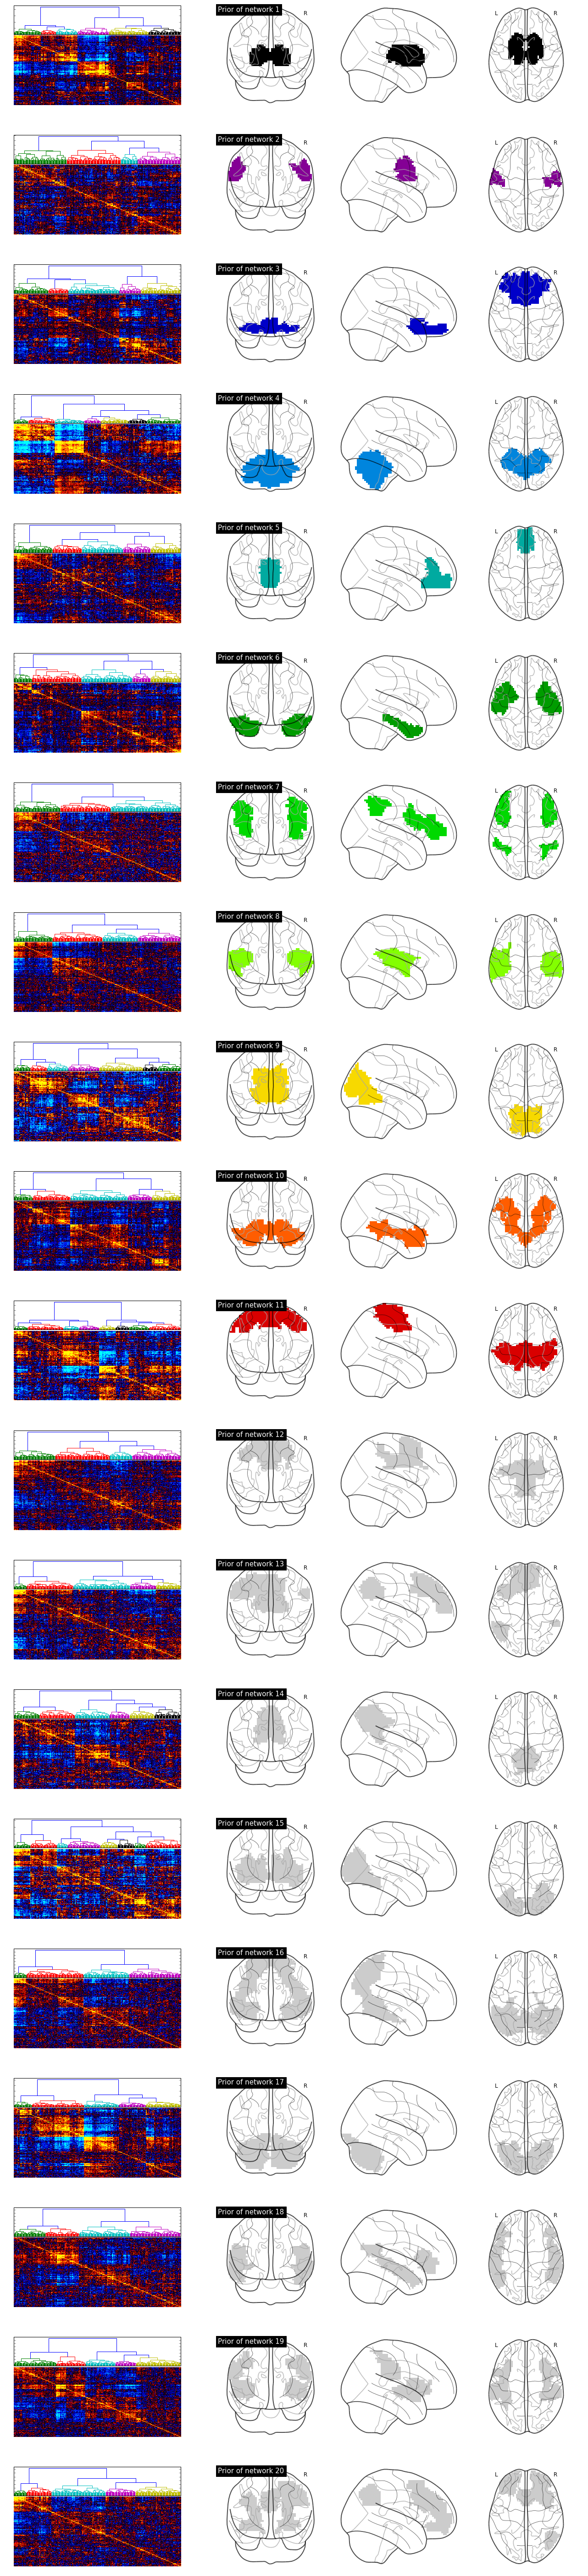

In [105]:
# Show the ordered similarity matrices
fig = plt.figure(figsize=(30,100))
gs = gridspec.GridSpec(scale, 4, hspace=0.3)
for net_id in np.arange(0,scale):
    ax = fig.add_subplot(gs[net_id,1])
    ay = fig.add_subplot(gs[net_id,2:])
    subdend = bb.visu.add_subplot_axes(ax, [0, 0.71, 1, 0.29])
    submat = bb.visu.add_subplot_axes(ax, [0, 0, 1, 0.7])
    ax.set_axis_off()
    submat.set_axis_off()
    
    simmat = corr_mat[net_id, ...]
    link = link_store[..., net_id]
    hier = scl.hierarchy.dendrogram(link, ax=subdend, color_threshold=6)
    idx = hier['leaves']
    tmp = simmat[idx, :]
    show_mat = tmp[:, idx]
    submat.matshow(show_mat, vmin=-0.2, vmax=0.2, cmap=hotcold, aspect='auto')
    
    subdend.set_yticklabels([])
    subdend.set_xticklabels([])
    
    nlp.plot_glass_brain(nil.image.index_img(prior_img, net_id), cmap=plt.cm.spectral, 
                         axes=ay, colorbar=False, title='Prior of network {}'.format(net_id+1),
                        vmin=1, vmax=12)

In [106]:
# Make the grand average
gdavg = np.zeros(mask.shape + (scale,))

In [107]:
netraw = np.load(netraw_path)

In [108]:
# Reduce the phenotype data to those subjects 
# that actually have the covariate of interest
cov_list = ['FIQ', 'VIQ', 'PIQ', 'ADI_R_SOCIAL_TOTAL_A',
            'ADI_R_VERBAL_TOTAL_BV', 'ADI_RRB_TOTAL_C', 
            'VINELAND_ABC_STANDARD', 'ADOS_TOTAL', 'SRS_RAW_TOTAL', 'DX_GROUP']
cov = cov_list[-1]
cov_index = pd.notnull(pheno.replace(-9999, np.nan)[cov])

In [109]:
cov_list = ['FIQ', 'VIQ', 'PIQ', 'ADI_R_SOCIAL_TOTAL_A',
            'ADI_R_VERBAL_TOTAL_BV', 'ADI_RRB_TOTAL_C', 
            'VINELAND_ABC_STANDARD', 'ADOS_TOTAL', 'SRS_RAW_TOTAL', 'DX_GROUP']
#sublist = np.int16(np.concatenate((np.arange(2,10,2), np.floor(np.logspace(1,2,6))),0))[:-2]
sublist = np.arange(3,8)
for subtypes in sublist:
    print('\n{} subtypes'.format(subtypes))
    scale = netstack.shape[0]
    n_sub = netstack.shape[2]
    n_vox = netstack.shape[1]

    link_store = np.zeros((n_sub-1,4,scale))
    part_store = np.zeros((scale, n_sub))
    sbt_store = np.zeros((scale, subtypes, n_vox))
    weight_store = np.zeros((scale, subtypes, n_sub))

    # Iterate through the networks
    for net_id in range(scale):
        # Compute linkage with Ward's criterion
        link_mat = scl.hierarchy.linkage(corr_mat[net_id, ...] , method='ward')
        link_store[..., net_id] = link_mat
        # Partition the linkage to get a given number of subtypes
        part_sub = scl.hierarchy.fcluster(link_mat, subtypes, criterion='maxclust')
        part_store[net_id, :] = part_sub

        sub_stack = np.zeros((n_vox, subtypes))
        for s_id in range(subtypes):
            sbt = np.mean(netstack[net_id, :, part_sub==s_id+1],0)
            sub_stack[:,s_id] = sbt
            sbt_store[net_id, s_id, :] = sbt

        # Init store - Compute the weights
        for s_id in range(subtypes):
            type_map = sub_stack[:, s_id]
            weight_store[net_id, s_id, :] = np.array([np.corrcoef(type_map, netstack[net_id, :, x])[0,1] for x in range(n_sub)])

        # Init store - Compute the weights
        for s_id in range(subtypes):
            type_map = sub_stack[:, s_id]
            weight_store[net_id, s_id, :] = np.array([np.corrcoef(type_map, netstack[net_id, :, x])[0,1] for x in range(n_sub)])

    for cov in cov_list:
        cov_index = pd.notnull(pheno.replace(-9999, np.nan)[cov])
        cov_pheno = pheno[cov_index]
        # Generate the model matrix
        factors = [cov, 'SEX', 'AGE_AT_SCAN', 'FD_scrubbed']
        # Make dummy variables for the site factor
        site_factor = pd.get_dummies(cov_pheno['SITE_ID'])
        # Turn the first site into the intercept
        site_factor = site_factor.rename(columns={site_factor.keys()[0]: 'INTERCEPT'})
        site_factor['INTERCEPT'] = 1
        # Get the other variables
        other_factors = cov_pheno.ix[:,factors]
        # Turn diagnosis into [0,1] vector
        #other_factors['DX_GROUP'] = other_factors['DX_GROUP'].values - 1
        # Demean age
        other_factors['AGE_AT_SCAN'] = other_factors['AGE_AT_SCAN']-np.mean(other_factors['AGE_AT_SCAN'].values)
        # Demean the covariate
        other_factors[cov] = other_factors[cov]-np.mean(other_factors[cov].values)
        # Put them back together
        glm_pheno = pd.concat([site_factor, other_factors], axis=1)
        cov_weight = weight_store[..., cov_index.values]
        res_store = list()
        pval_store = np.zeros((scale, subtypes))
        for net_id in range(scale):
            res_list = list()
            # Loop through the subtypes
            for s_id in range(subtypes):
                model = sm.OLS(cov_weight[net_id, s_id, :], glm_pheno)
                results = model.fit()
                # Save the p-values
                pval_store[net_id, s_id] = results.pvalues[cov]
                res_list.append(results)
            res_store.append(res_list)
        # Now look at the mask of p-values passing FDR Correction
        pval_vec = np.reshape(pval_store, np.prod(pval_store.shape))
        pcorr_vec = smi.multipletests(pval_vec.flatten(), alpha=0.05, method='fdr_bh')
        # pcorr_vec = sts.multicomp.fdrcorrection0(pval_vec, 0.05)
        # Find the hits
        if np.sum(pcorr_vec[0]) > 0:
            pcorr_store = np.reshape(pcorr_vec[0], pval_store.shape)
            hits = np.argwhere(pcorr_store!=0)
            print('    {} findings for {} ({})'.format(np.sum(pcorr_vec[0]), cov, list(hits)))
        else:
            print('    {} findings for {}'.format(np.sum(pcorr_vec[0]), cov))


3 subtypes
    0 findings for FIQ
    4 findings for VIQ ([array([4, 0]), array([4, 1]), array([7, 0]), array([7, 1])])
    0 findings for PIQ
    0 findings for ADI_R_SOCIAL_TOTAL_A
    0 findings for ADI_R_VERBAL_TOTAL_BV
    0 findings for ADI_RRB_TOTAL_C
    0 findings for VINELAND_ABC_STANDARD
    6 findings for ADOS_TOTAL ([array([4, 0]), array([7, 0]), array([7, 1]), array([10,  0]), array([10,  1]), array([10,  2])])
    0 findings for SRS_RAW_TOTAL
    17 findings for DX_GROUP ([array([0, 0]), array([0, 1]), array([0, 2]), array([1, 1]), array([1, 2]), array([4, 0]), array([4, 2]), array([7, 0]), array([7, 1]), array([9, 1]), array([10,  0]), array([10,  1]), array([10,  2]), array([11,  2]), array([14,  0]), array([14,  1]), array([17,  2])])

4 subtypes
    0 findings for FIQ
    6 findings for VIQ ([array([3, 2]), array([4, 0]), array([4, 1]), array([4, 2]), array([7, 0]), array([7, 1])])
    0 findings for PIQ
    0 findings for ADI_R_SOCIAL_TOTAL_A
    0 findings for ADI

In [110]:
print(res_list[0].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.262
Model:                            OLS   Adj. R-squared:                  0.230
Method:                 Least Squares   F-statistic:                     8.040
Date:                Sat, 07 Nov 2015   Prob (F-statistic):           8.80e-14
Time:                        14:43:15   Log-Likelihood:                 112.23
No. Observations:                 308   AIC:                            -196.5
Df Residuals:                     294   BIC:                            -144.2
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT      -0.4134      0.068     -6.104      

In [111]:
print('{} has {}'.format(cov, np.sum(cov_index)))

DX_GROUP has 308


In [112]:
cov_pheno = pheno[cov_index]
# Generate the model matrix
factors = [cov, 'SEX', 'AGE_AT_SCAN', 'FD_scrubbed']
# Make dummy variables for the site factor
site_factor = pd.get_dummies(cov_pheno['SITE_ID'])
# Turn the first site into the intercept
site_factor = site_factor.rename(columns={site_factor.keys()[0]: 'INTERCEPT'})
site_factor['INTERCEPT'] = 1
# Get the other variables
other_factors = cov_pheno.ix[:,factors]
# Turn diagnosis into [0,1] vector
#other_factors['DX_GROUP'] = other_factors['DX_GROUP'].values - 1
# Demean age
other_factors['AGE_AT_SCAN'] = other_factors['AGE_AT_SCAN']-np.mean(other_factors['AGE_AT_SCAN'].values)
# Demean the covariate
other_factors[cov] = other_factors[cov]-np.mean(other_factors[cov].values)
# Put them back together
glm_pheno = pd.concat([site_factor, other_factors], axis=1)

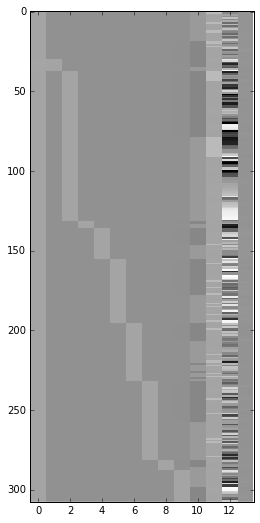

In [113]:
fig = plt.figure(figsize=(4,10))
ax = fig.add_subplot(111)
ax.imshow(glm_pheno, aspect=0.1, interpolation='None', cmap=plt.cm.Greys_r)

In [114]:
cov_weight = weight_store[..., cov_index.values]

In [115]:
res_store = list()
pval_store = np.zeros((scale, subtypes))
for net_id in range(scale):
    res_list = list()
    # Loop through the subtypes
    for s_id in range(subtypes):
        model = sm.OLS(cov_weight[net_id, s_id, :], glm_pheno)
        results = model.fit()
        # Save the p-values
        pval_store[net_id, s_id] = results.pvalues[cov]
        res_list.append(results)
    res_store.append(res_list)

# Look at the results

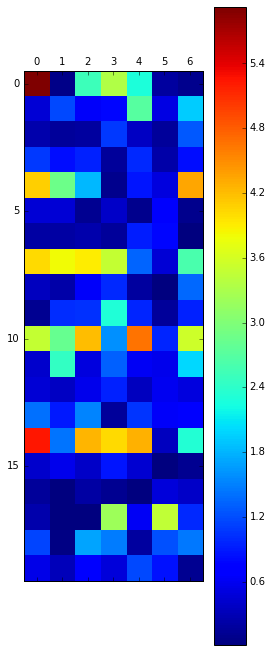

In [116]:
# Look at the uncorrected p-values for the GLM with diagnosis across networks
tmp = plt.matshow(-np.log10(pval_store))
tmp = plt.colorbar()

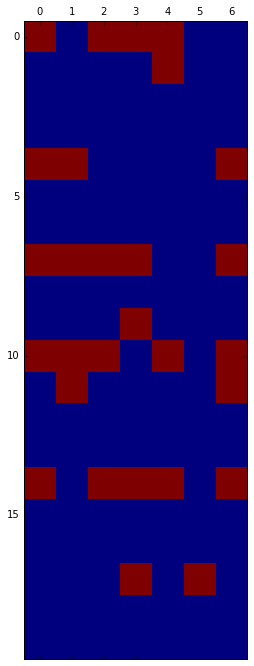

In [117]:
# Now look at the mask of p-values passing FDR Correction
pval_vec = np.reshape(pval_store, np.prod(pval_store.shape))
pcorr_vec = sts.multicomp.fdrcorrection0(pval_vec, 0.05)
pcorr_store = np.reshape(pcorr_vec[0], pval_store.shape)
tmp = plt.matshow(pcorr_store)

In [118]:
print(res_store[4][1].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     5.717
Date:                Sat, 07 Nov 2015   Prob (F-statistic):           2.34e-09
Time:                        14:43:16   Log-Likelihood:                 111.92
No. Observations:                 308   AIC:                            -195.8
Df Residuals:                     294   BIC:                            -143.6
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT      -0.2998      0.068     -4.422      

In [119]:
print(res_store[4][2].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     5.263
Date:                Sat, 07 Nov 2015   Prob (F-statistic):           1.77e-08
Time:                        14:43:16   Log-Likelihood:                 116.97
No. Observations:                 308   AIC:                            -205.9
Df Residuals:                     294   BIC:                            -153.7
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT       0.3718      0.067      5.574      

In [120]:
gdavg_img = nib.Nifti1Image(gdavg, affine=m_img.get_affine(), header=m_img.get_header())

In [121]:
# vr = np.concatenate((np.arange(-55,-35,5), np.arange(40,55,5)))
vr = np.array([-55,-50,-45,-40,0,40,45,50,55])
fig_n2_sbt_5 = show_subtype(4, 1, gdavg_img, sbt_store_2, sbt_store, threshold=0.02, view_range=vr, view_mode='x')

NameError: name 'sbt_store_2' is not defined